1/1 [==============================] - 1s 502ms/step
0 [D loss: 0.6957046985626221, acc.: 29.69%] [G loss: 0.6969870328903198]
1/1 [==============================] - 0s 134ms/step
1 [D loss: 0.6584329903125763, acc.: 93.75%] [G loss: 0.665320634841919]
1/1 [==============================] - 0s 80ms/step
2 [D loss: 0.6266957223415375, acc.: 100.00%] [G loss: 0.6419901251792908]
1/1 [==============================] - 0s 71ms/step
3 [D loss: 0.5931204557418823, acc.: 100.00%] [G loss: 0.6226599216461182]
1/1 [==============================] - 0s 76ms/step
4 [D loss: 0.5594254434108734, acc.: 100.00%] [G loss: 0.6123230457305908]
1/1 [==============================] - 0s 80ms/step
5 [D loss: 0.523471474647522, acc.: 100.00%] [G loss: 0.5867466926574707]
1/1 [==============================] - 0s 70ms/step
6 [D loss: 0.47166651487350464, acc.: 100.00%] [G loss: 0.5717925429344177]
1/1 [==============================] - 0s 74ms/step
7 [D loss: 0.4065683037042618, acc.: 100.00%] [G loss: 0.560

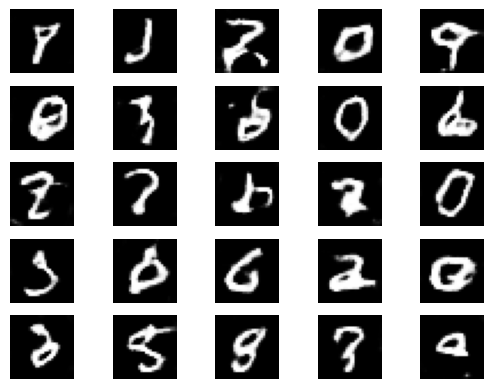

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os

# Load and preprocess the MNIST dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 127.5 - 1.0  # Normalize to [-1, 1]
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')

# Function to build the generator model
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))
    return model

# Function to build the discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Function to build and compile the GAN model
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Initialize and compile models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the GAN
discriminator.trainable = False  # Only train the generator within the GAN model
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Create directory to save generated images
if not os.path.exists('dcgan_images'):
    os.makedirs('dcgan_images')

# Function to train the GAN
def train_gan(epochs, batch_size=128, save_interval=200):
    X_train = x_train
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        real = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print progress
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss}]")

        # Save generated images at intervals
        if epoch % save_interval == 0:
            save_imgs(epoch)

# Function to save generated images
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"dcgan_images/mnist_{epoch}.png")
    plt.close()

# Train the GAN
train_gan(epochs=10000, batch_size=64, save_interval=200)

# Function to generate and display images
def generate_images(num_images=25):
    noise = np.random.normal(0, 1, (num_images, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images to [0, 1]

    r, c = 5, 5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

generate_images()
